In [1]:
cd ../TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Compute Qj given ground truth T

In [4]:
import pandas as pd 
from qualityBaseline import *
import pickle as pkl

In [5]:
Qj={}

In [7]:
import shapely

In [ ]:
my_BBG  = pd.read_csv("my_ground_truth.csv")
Qj={}
for object_id in tqdm(list(set(my_BBG.object_id))):
    ground_truth_match = my_BBG[my_BBG.object_id==object_id]
    x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
    T = Polygon(zip(x_locs,y_locs))
    DATA_DIR ="output"
    tiles = pkl.load(open(DATA_DIR+"/tiles{}.pkl".format(object_id)))
    indMat = pkl.load(open(DATA_DIR+"/indMat{}.pkl".format(object_id)))
    workers = pkl.load(open(DATA_DIR+"/worker{}.pkl".format(object_id)))
    for wid,j in zip(workers,range(len(workers))):
        Ncorrect=0
        Nwrong = 0
        for k in range(len(tiles)): 
            tk = tiles[k]
            ljk = indMat[j][k]
            try:
                overlap = T.intersection(tk).area/T.area>0.8
                tjkInT = T.contains(tk) or overlap
            except(shapely.geos.TopologicalError):
                overlap=True
                tjkInT = T.contains(tk)
            
            if (ljk ==1 and tjkInT) or (ljk ==0 and (not tjkInT)):
                Ncorrect+=1
            elif (ljk ==1 and (not tjkInT)) or (ljk ==0 and tjkInT):
                Nwrong+=1
        qj = Ncorrect/float(Ncorrect+Nwrong)
        if wid in Qj:
            Qj[wid].append(qj)
        else:
            Qj[wid]=[qj]
pkl.dump(Qj,open("Qj.pkl",'w'))

  0%|          | 0/47 [00:00<?, ?it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (363.536 192.518, 364.544 190.67) and LINESTRING (364.131 191.426, 363.205 193.123) at 363.81178285165623 192.01173143863031
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (363.536 192.518, 364.544 190.67) and LINESTRING (364.131 191.426, 363.205 193.123) at 363.81178285165623 192.01173143863031
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (363.536 192.518, 364.544 190.67) and LINESTRING (364.131 191.426, 363.205 193.123) at 363.81178285165623 192.01173143863031
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (363.536 192.518, 364.544 190.67) and LINESTRING (364.131 191.426, 363.205 193.123) at 363.81178285165623 192.01173143863031
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (363.536 192.518, 364.544 190.67

In [ ]:
Qj

In [5]:
Qj=pkl.load(open("Qj_no_overlap_exact_containment.pkl",'r'))

In [10]:
Qj[140][0]

0.47957371225577267

In [8]:
Qj[131][0]

0.5739659984775438

In [137]:
from  analysis_toolbox import *

In [144]:
cd crowd-seg/analysis/TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


### Examples of good workers

In [108]:
def visualize_bb_objects(object_id,img_bkgrnd=True,worker_id=-1,gtypes=['worker','self'],single=False,bb_info=""):
    '''
    Plot BB for the object corresponding to the given object_id
    #Still need to implement COCO later...
    gtypes: list specifying the types of BB to be plotted (worker=all worker's annotation, 'self'=self BBG)
    '''
    if not single:
        img_info,object_tbl,bb_info,hit_info=load_info()
    else:
        img_info,object_tbl,bb_info_bad,hit_info=load_info()
    plt.figure(figsize =(7,7))
    ground_truth = pd.read_csv("../../../../data/object_ground_truth.csv")
    my_BBG  = pd.read_csv("../my_ground_truth.csv")
    if img_bkgrnd:
        img_name = img_info[img_info.id==int(object_tbl[object_tbl.id==object_id]["image_id"])]["filename"].iloc[0]
        fname = "../../../web-app/app/static/"+img_name+".png"
        img=mpimg.imread(fname)
        width,height = get_size(fname)
        img_id = int(img_name.split('_')[-1])
        plt.imshow(img)
        plt.xlim(0,width)
        plt.ylim(height,0)
        plt.axis("off")   
    else:
        plt.gca().invert_yaxis()
    plt.title("Object {0} [{1}]".format(object_id,object_tbl[object_tbl.object_id==object_id]["name"].iloc[0]))
#         plt.fill_between(x_locs,y_locs,color='none',facecolor='#f442df', alpha=0.5)
    if 'worker' in gtypes:
        bb_objects = bb_info[bb_info["object_id"]==object_id]
        if worker_id!=-1:
            bb = bb_objects[bb_objects["worker_id"]==worker_id]
            xloc,yloc =  process_raw_locs([bb["x_locs"].iloc[0],bb["y_locs"].iloc[0]])    
        
            plt.plot(xloc,yloc,'-',color='cyan',linewidth=3)
            plt.fill_between(xloc,yloc,color='none',facecolor='#f442df', alpha=0.01)
        else:
            for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"]):
                xloc,yloc = process_raw_locs([x,y])
                if single:
                    plt.plot(xloc,yloc,'-',color='#f442df',linewidth=4)
                else:
                    plt.plot(xloc,yloc,'-',color='#f442df',linewidth=1)
                    plt.fill_between(xloc,yloc,color='none',facecolor='#f442df', alpha=0.01)
    if 'self' in gtypes:
        ground_truth_match = my_BBG[my_BBG.object_id==object_id]
        x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
        if single:
            plt.plot(x_locs,y_locs,'--',color='#0000ff',linewidth=2)
        else: 
            plt.plot(x_locs,y_locs,'-',color='#0000ff',linewidth=4)
    # elif gtype=='COCO':
    #     ground_truth_match = my_BBG[my_BBG.object_id==object_id]
    if not single:plt.savefig("bb_object_{}.pdf".format(object_id))

In [106]:
def visualize_bb_worker(worker_id,gtypes=['worker','self']):
    '''
    Plot BB for the object corresponding to the given object_id
    #Still need to implement COCO later...
    gtypes: list specifying the types of BB to be plotted (worker=all worker's annotation, 'self'=self BBG)
    '''
    img_info,object_tbl,bb_info,hit_info=load_info()
    ground_truth = pd.read_csv("../../../../data/object_ground_truth.csv")
    my_BBG  = pd.read_csv("../my_ground_truth.csv")
    filtered_bb_info=bb_info[bb_info["worker_id"]==worker_id]
    for object_id in list(filtered_bb_info.object_id):
        visualize_bb_objects(object_id,single=True,gtypes=gtypes,bb_info=filtered_bb_info)
#         plt.suptitle("Worker {}".format(worker_id))
    #plt.savefig("bb_worker_{0}_object_{1}.pdf".format(worker_id,object_id))

In [88]:
Qj_mean={}
for wid, qj in Qj.iteritems():
    Qj_mean[wid]=mean(qj)

In [89]:
top10workers=np.array(Qj.keys())[np.argsort(Qj_mean.values())[::-1][:10]]

In [90]:
top5workers=np.array(Qj.keys())[np.argsort(Qj_mean.values())[::-1][:5]]

In [111]:
[Qj[wid] for wid in top10workers]

[[0.6109544905356423, 0.9601399961112191, 0.9724325961829748],
 [0.8218872138470128],
 [0.7912379688018586],
 [0.780672523477734],
 [0.7668393782383419],
 [0.7568790049001131],
 [0.7566137566137566],
 [0.7522012578616353],
 [0.7491103202846975],
 [0.740072202166065]]

In [91]:
[Qj_mean[wid] for wid in top10workers]

[0.84784236094327881,
 0.8218872138470128,
 0.79123796880185859,
 0.78067252347773397,
 0.76683937823834192,
 0.75687900490011306,
 0.75661375661375663,
 0.75220125786163528,
 0.74911032028469748,
 0.74007220216606495]

In [98]:
cd output/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM/output


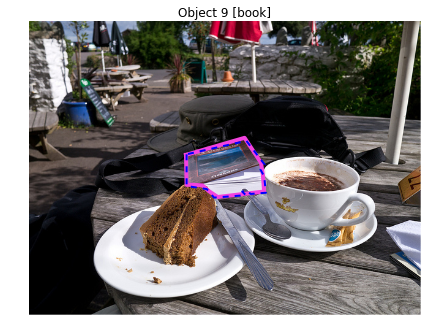

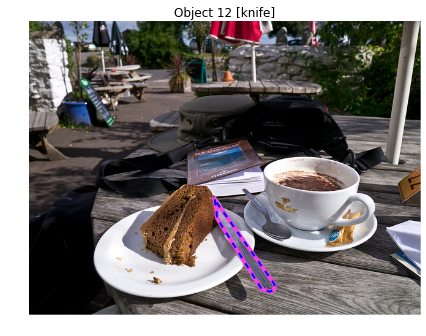

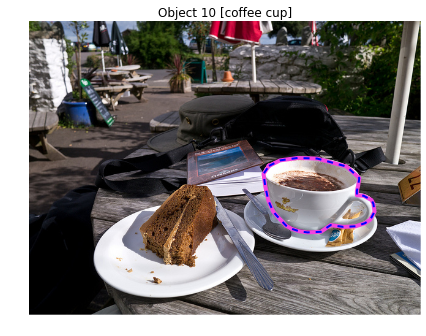

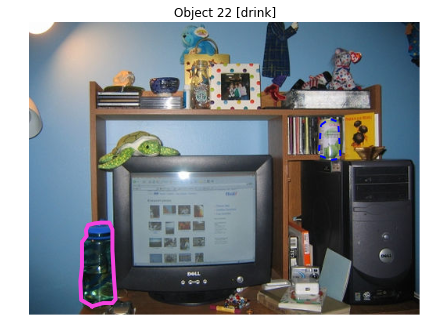

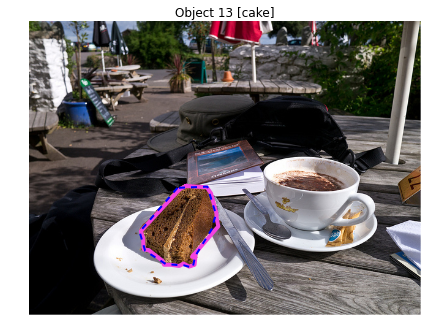

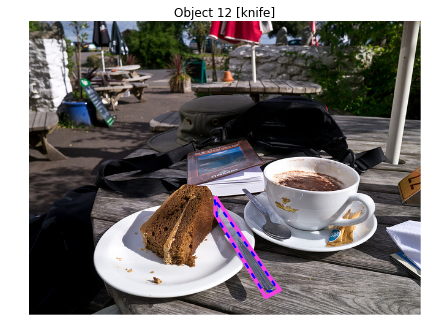

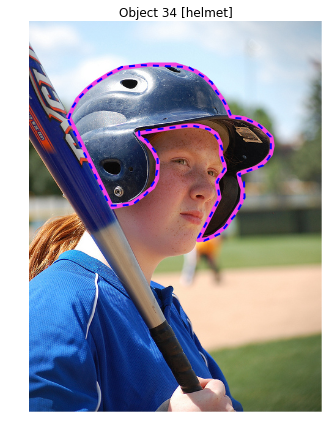

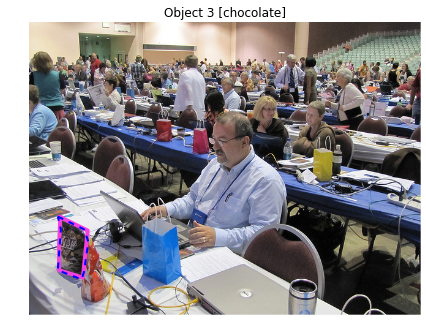

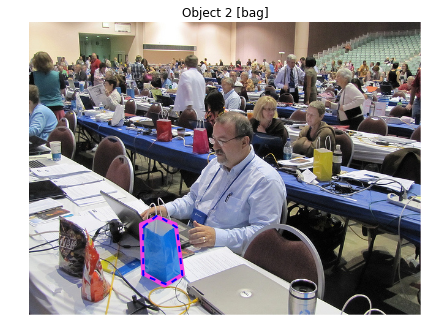

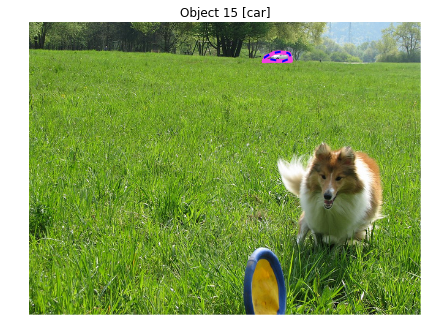

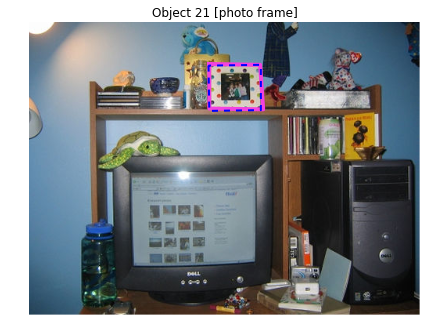

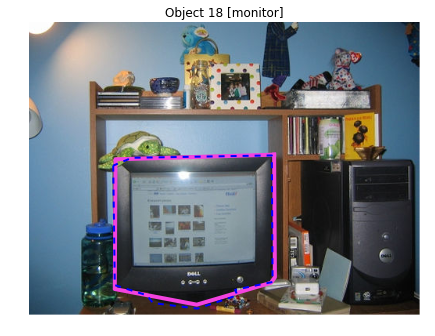

In [110]:
for wid in top10workers: 
    visualize_bb_worker(wid)

In [215]:
solnset= [0,4,12,34]
Tprime = np.array(tiles)[solnset]

In [112]:
Qj_mean={}
for wid, qj in Qj.iteritems():
    Qj_mean[wid]=mean(qj)
plk = []
for k in range(len(Tprime)): 
    tk = tiles[k]
    ljk = indMat[j][k]
    tjkInT = T.contains(tk) 
    qj = Qj_mean[wid]
    if (ljk ==1 and tjkInT) or (ljk ==0 and (not tjkInT)):
        plk.append(qj)
    elif (ljk ==1 and (not tjkInT)) or (ljk ==0 and tjkInT):
        plk.append(1-qj)

In [223]:
mean(plk)

0.51881103936234918

In [6]:
cd ..

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [3]:
from TileEM_plot_toolbox import *

In [7]:
DATA_DIR = "output"
os.chdir(DATA_DIR)
gamma_properties=False
# try: 
#     topTilePickHeuristic=sys.argv[1]
# except(IndexError):
#     topTilePickHeuristic="area"
topTilePickHeuristic="area"
topk = 40
training_tbl = []
my_BBG  = pd.read_csv("../../my_ground_truth.csv")
import itertools
for objid in tqdm(object_lst):
    # print "working on obj",objid
    #Get Tile information for that object
    worker_ids,worker_precision_lst,worker_recall_lst = compute_worker_PR_obj(objid,return_worker_id=True)
    tiles = pkl.load(open("../{0}/tiles{1}.pkl".format(DATA_DIR,objid),'r'))
    worker_ids = pkl.load(open("../{0}/worker{1}.pkl".format(DATA_DIR,objid),'r'))
    indicatorMat = pkl.load(open("../{0}/indMat{1}.pkl".format(DATA_DIR,objid),'r'))
    if gamma_properties : 
        gammas = pkl.load(open("gfile{}.pkl".format(objid),'r'))
        if  list(gammas[0])==[] and topTilePickHeuristic=='gamma' :
            print "No Gamma information for this object, going onto the next"
            continue

    #using the area information in the last row 
    tile_area = np.array(indicatorMat[-1])
    # Loop through all combinations of 20 randomly chosen tiles 
    # tile_subset_idx = np.random.choice(np.arange(len(tiles)),20)
    ground_truth_match = my_BBG[my_BBG.object_id==objid]
    x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
    BBG = shapely.geometry.Polygon(zip(x_locs,y_locs))
    tile_area_ratio = tile_area/BBG.area
     
    if topTilePickHeuristic=="area": 
        # Loop through all combinations of 40 top-area tiles 
        # print "area heuristic"
        tile_subset_idx = tile_area_ratio.argsort()[::-1][:topk]
    elif topTilePickHeuristic=="gamma":
        # print "gamma"
        tile_subset_idx = np.argsort(gammas[0])[::-1][:topk]
    elif topTilePickHeuristic=="majvote":
        # print "majvote"
        tile_votes = np.sum(indicatorMat[:-1],axis=0)
        tile_subset_idx = np.argsort(tile_votes)[::-1][:topk]

    rand_subset =[]
    for i in range(3000):
        NumTilesInCombo= np.random.randint(0,topk)
        tidxInCombo= np.random.choice(tile_subset_idx,NumTilesInCombo,replace=False)
        rand_subset.append(tidxInCombo)
    # combs = []
    # for i in range(1, len(tile_subset_idx)+1):
    #     els = [list(x) for x in itertools.combinations(tile_subset_idx, i)]
    #     combs.extend(els)
    # # Compute metric values for 3000 of these tile combinations
    # rand_subset = np.random.choice(combs,3000)
    for Tprime in rand_subset:
        p,r =compute_PR(objid,Tprime,tiles)
        gvals=[]
        experiment_idx=0
        # Majority Votes 
        region_votes=[]
        Tareas=[]
        for tidx in Tprime:
            #Number of votes for that tile
            region_votes.append(np.sum(indicatorMat[:-1][:,tidx]))

            if gamma_properties:
                if gammas!=[]:
                    gvals.append(gammas[experiment_idx][tidx])
                else:
                    gvals.append(0)

            Tareas.append(Polygon(tiles[tidx]).area)
        training_tbl.append([objid,Tprime,np.sum(region_votes), np.mean(region_votes),np.sum(gvals),np.mean(gvals),np.sum(Tareas),np.mean(Tareas),p,r])
        # Worker Qualities computed by ground truth         
        Qj=pkl.load(open("../Qj.pkl",'r'))
        Qj_mean={}
        for wid, qj in Qj.iteritems():
            Qj_mean[wid]=mean(qj)
        plk = []
        for k in range(len(Tprime)): 
            tk = tiles[k]
            ljk = indicatorMat[j][k]
            tjkInT = T.contains(tk)
            qj = Qj_mean[wid]
            if (ljk ==1 and tjkInT) or (ljk ==0 and (not tjkInT)):
                plk.append(qj)
            elif (ljk ==1 and (not tjkInT)) or (ljk ==0 and tjkInT):
                plk.append(1-qj)

  0%|          | 0/47 [00:00<?, ?it/s]

NameError: name 'j' is not defined

In [8]:
Tprime

array([2557, 1561, 2554, 3291, 2707, 1671, 1835,  401, 2134, 3594, 2783,
       2929, 1558, 3262])

In [21]:
cd output/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM/output


In [58]:

# for objid in tqdm(list(set(my_BBG.object_id))):
#     ground_truth_match = my_BBG[my_BBG.object_id==objid]
#     x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
#     T = Polygon(zip(x_locs,y_locs))
#     tiles = pkl.load(open("tiles{}.pkl".format(objid)))
#     indicatorMat = pkl.load(open("indMat{}.pkl".format(objid)))
#     workers = pkl.load(open("worker{}.pkl".format(objid)))
pTprime=[]
for Tprime in tqdm(rand_subset[:100]):
    # Worker Qualities computed by ground truth         
    Qj=pkl.load(open("../Qj.pkl",'r'))
    Qj_mean={}
    for wid, qj in Qj.iteritems():
        Qj_mean[wid]=mean(qj)

    workers = pkl.load(open("worker{}.pkl".format(objid)))
    for k in range(len(Tprime)): 
        plk=[]
        for j in  range(len(workers)):
            tk = tiles[k]
            ljk = indicatorMat[j][k]
            tjkInT = T.contains(tk)
            qj = Qj_mean[wid]
            if (ljk ==1 and tjkInT) or (ljk ==0 and (not tjkInT)):
                plk.append(qj)
            elif (ljk ==1 and (not tjkInT)) or (ljk ==0 and tjkInT):
                plk.append(1-qj)
    pTprime.append(np.product(plk))

In [59]:
len(pTprime)

100

In [60]:
len(pTprime)

100

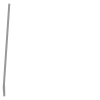

In [62]:
np.argmax(pTprime)

In [65]:
cd ..

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [66]:
DATA_DIR = "output"
os.chdir(DATA_DIR)
gamma_properties=False
# try: 
#     topTilePickHeuristic=sys.argv[1]
# except(IndexError):
#     topTilePickHeuristic="area"
topTilePickHeuristic="area"
topk = 40
training_tbl = []
my_BBG  = pd.read_csv("../../my_ground_truth.csv")
import itertools
for objid in tqdm(object_lst):
    # print "working on obj",objid
    #Get Tile information for that object
    worker_ids,worker_precision_lst,worker_recall_lst = compute_worker_PR_obj(objid,return_worker_id=True)
    tiles = pkl.load(open("../{0}/tiles{1}.pkl".format(DATA_DIR,objid),'r'))
    worker_ids = pkl.load(open("../{0}/worker{1}.pkl".format(DATA_DIR,objid),'r'))
    indicatorMat = pkl.load(open("../{0}/indMat{1}.pkl".format(DATA_DIR,objid),'r'))
    if gamma_properties : 
        gammas = pkl.load(open("gfile{}.pkl".format(objid),'r'))
        if  list(gammas[0])==[] and topTilePickHeuristic=='gamma' :
            print "No Gamma information for this object, going onto the next"
            continue
    # Worker Qualities computed by ground truth   
    Qj=pkl.load(open("../Qj.pkl",'r'))
    Qj_mean={}
    for wid, qj in Qj.iteritems():
        Qj_mean[wid]=mean(qj)
    #using the area information in the last row 
    tile_area = np.array(indicatorMat[-1])
    # Loop through all combinations of 20 randomly chosen tiles 
    # tile_subset_idx = np.random.choice(np.arange(len(tiles)),20)
    ground_truth_match = my_BBG[my_BBG.object_id==objid]
    x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
    BBG = shapely.geometry.Polygon(zip(x_locs,y_locs))
    tile_area_ratio = tile_area/BBG.area
     
    if topTilePickHeuristic=="area": 
        # Loop through all combinations of 40 top-area tiles 
        # print "area heuristic"
        tile_subset_idx = tile_area_ratio.argsort()[::-1][:topk]
    elif topTilePickHeuristic=="gamma":
        # print "gamma"
        tile_subset_idx = np.argsort(gammas[0])[::-1][:topk]
    elif topTilePickHeuristic=="majvote":
        # print "majvote"
        tile_votes = np.sum(indicatorMat[:-1],axis=0)
        tile_subset_idx = np.argsort(tile_votes)[::-1][:topk]

    rand_subset =[]
    for i in range(10):
        NumTilesInCombo= np.random.randint(0,topk)
        tidxInCombo= np.random.choice(tile_subset_idx,NumTilesInCombo,replace=False)
        rand_subset.append(tidxInCombo)
    # combs = []
    # for i in range(1, len(tile_subset_idx)+1):
    #     els = [list(x) for x in itertools.combinations(tile_subset_idx, i)]
    #     combs.extend(els)
    # # Compute metric values for 3000 of these tile combinations
    # rand_subset = np.random.choice(combs,3000)
    for Tprime in rand_subset:
        p,r =compute_PR(objid,Tprime,tiles)
        gvals=[]
        experiment_idx=0
        # Majority Votes 
        region_votes=[]
        Tareas=[]
        for tidx in Tprime:
            #Number of votes for that tile
            region_votes.append(np.sum(indicatorMat[:-1][:,tidx]))

            if gamma_properties:
                if gammas!=[]:
                    gvals.append(gammas[experiment_idx][tidx])
                else:
                    gvals.append(0)

            Tareas.append(Polygon(tiles[tidx]).area)
        
               
        workers = pkl.load(open("worker{}.pkl".format(objid)))
        for k in range(len(Tprime)): 
            plk=[]
            for j in  range(len(workers)):
                tk = tiles[k]
                ljk = indicatorMat[j][k]
                tjkInT = T.contains(tk)
                qj = Qj_mean[wid]
                if (ljk ==1 and tjkInT) or (ljk ==0 and (not tjkInT)):
                    plk.append(qj)
                elif (ljk ==1 and (not tjkInT)) or (ljk ==0 and tjkInT):
                    plk.append(1-qj)
        pTprime=np.product(plk)
        training_tbl.append([objid,Tprime,np.sum(region_votes), np.mean(region_votes),np.sum(gvals),np.mean(gvals),np.sum(Tareas),np.mean(Tareas),pTprime,p,r])

  0%|          | 0/47 [00:00<?, ?it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (316.737 150.053, 320.667 148.333) and LINESTRING (318.8 149.64, 322.261 147.217) at 320.66666666666669 148.33333333333331
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (316.737 150.053, 320.667 148.333) and LINESTRING (318.8 149.64, 322.261 147.217) at 320.66666666666669 148.33333333333331
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (316.737 150.053, 320.667 148.333) and LINESTRING (318.8 149.64, 322.261 147.217) at 320.66666666666669 148.33333333333331
ERROR:shapely.geos:TopologyException: side location conflict at 329 241
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (335.639 151.8, 343.545 153.88) and LINESTRING (351.482 155.969, 341.736 153.404) at 343.50303286231951 153.86921917429461
ERROR:shapely.geos:TopologyException: side location co

KeyboardInterrupt: 

In [68]:
df = pd.DataFrame(training_tbl,columns=["objid","T prime","Total Votes","Average Votes","Total gamma value","Average gamma value",\
                                        "Total area","Average area","pTprime","Precision","Recall"])

In [69]:
df

objid                                            T prime  Total Votes  \
0       1  [3178, 80, 401, 3112, 3262, 1899, 3141, 2781, ...          658   
1       1  [3263, 2707, 3396, 3111, 1899, 2462, 2554, 308...          710   
2       1  [2134, 3178, 1899, 1671, 3263, 2600, 3538, 231...          675   
3       1  [3141, 3111, 3263, 185, 3291, 180, 80, 1899, 1...          156   
4       1  [1561, 3111, 180, 2134, 2299, 1835, 2783, 2163...          464   
5       1  [2554, 3396, 2482, 1561, 3141, 3301, 3111, 255...          463   
6       1  [1561, 3141, 3263, 185, 2557, 2482, 402, 2299,...          486   
7       1                                             [3263]           33   
8       1  [2707, 2462, 3594, 3263, 1835, 1671, 1318, 231...          816   
9       1                                             [2781]           31   
10      2                [650, 1738, 1699, 1576, 1820, 1922]          196   
11      2                                             [2129]           35   
12      2  [1901, 1216, 647, 1671, 1550, 1576, 66, 301, 6...         1165   
13      2  [1369, 1182, 1627, 1576, 2226, 598, 2129, 701,...          530   
14      2  [1550, 701, 100, 1216, 1369, 689, 2199, 1820, ...          872   
15      2  [650, 231, 1369, 647, 1820, 1922, 2199, 1182, ...          492   
16      2  [538, 689, 815, 1161, 1216, 2226, 231, 1369, 1...          682   
17      2                         [1886, 701, 630, 1631, 66]          134   
18      2  [1369, 66, 1390, 1568, 815, 385, 100, 1901, 70...          376   
19      2                 [385, 1576, 231, 1699, 1941, 1886]          193   
20      3  [1223, 2522, 2059, 2637, 1671, 63, 1621, 2549,...          977   
21      3  [830, 934, 1987, 63, 535, 2549, 110, 59, 252, ...          726   
22      3  [1671, 1909, 1794, 24, 2059, 2549, 2637, 2127,...          360   
23      3  [1223, 1671, 110, 1479, 1909, 830, 2633, 59, 1...         1124   
24      3  [2485, 252, 24, 2158, 1579, 830, 1987, 2400, 2...          334   
25      3      [2633, 2319, 28, 617, 1479, 2485, 1943, 2059]          221   
26      3  [2400, 24, 2637, 2053, 830, 1671, 1120, 934, 1...         1049   
27      3                                             [2485]           35   
28      3                                         [1621, 59]           40   
29      3                       [1579, 1943, 110, 1909, 338]          116   
..    ...                                                ...          ...   
50      6  [330, 1658, 19, 154, 841, 329, 334, 1994, 324,...          869   
51      6                                             [1229]           38   
52      6  [11, 334, 1908, 1658, 329, 1717, 2090, 324, 12...          947   
53      6  [1676, 19, 840, 788, 418, 1658, 1523, 329, 97,...          912   
54      6  [1038, 1708, 330, 585, 334, 1899, 1334, 1638, ...          509   
55      6  [1536, 1038, 1334, 40, 330, 1908, 840, 254, 97...          381   
56      6  [1229, 1248, 585, 418, 11, 40, 97, 788, 2055, ...          916   
57      6  [2090, 101, 1536, 127, 1899, 1334, 1708, 1523,...          566   
58      6  [154, 330, 1658, 585, 1499, 1523, 1334, 841, 3...          508   
59      6  [1616, 1523, 788, 324, 334, 418, 2090, 154, 33...          869   
60      7                                        [879, 2888]           56   
61      7                              [588, 1897, 542, 792]           66   
62      7  [792, 274, 2233, 762, 414, 1603, 788, 588, 296...          755   
63      7  [296, 1535, 2917, 788, 543, 542, 791, 3137, 87...          727   
64      7                                  [2233, 2382, 534]           77   
65      7  [274, 1651, 534, 2376, 2233, 229, 3191, 713, 5...          569   
66      7  [789, 2241, 543, 3012, 762, 511, 925, 414, 169...          449   
67      7  [2888, 925, 2160, 294, 3137, 1651, 2917, 2233,...          364   
68      7  [879, 511, 2382, 543, 789, 791, 2241, 13, 2233...          765   
69      7  [1535, 3137, 2786, 2160, 227, 3190, 1614, 762,...          212   
